# **INTRODUCTION**

<img src='Utils/dia.jpeg' alt='diabetes' width=800>

#### Diabetes is a widespread metabolic disorder affecting millions globally, necessitating accurate classification for effective management and prevention of complications

# **Business Understanding**

#### In healthcare, diabetes classification profoundly influences treatment efficacy. Traditional methods often overlook nuances, hindering personalized care. Leveraging machine learning, this project aims to refine classification by analyzing diverse patient data, including demographics and medical history. By developing a model capable of accurately categorizing diabetes subtypes and predicting complications, we aim to empower healthcare providers with a sophisticated tool for tailored interventions, ultimately enhancing patient care and outcomes

In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score
from sklearn.tree import  DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import chi2_contingency, ttest_ind
import warnings

warnings.filterwarnings("ignore")

from Utils.features import preprocess_and_encode_features,convert_dtypes,categorical_encoding,feature_elimination
from Utils.plotting import plot_confusion_matrix,plot_feature_importance
from Utils.model import grid_search_and_predict, train_and_evaluate
from Utils.metrics import classification_metrics
from Utils.visualization import plot_feature_importance, plot_confusion_matrix
# Palette of colors used for the plots
red  = '#BE3232'
blue = '#2D4471' 

# **1. Data Preprocessing**

In [2]:
df = pd.read_csv('Data/raw/diabetes-indicators-balanced-5050split.csv')
df.head(2)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0


In [3]:
print("before:",df.shape)
# Search for duplicated instances and drop
print("Duplications:",df.duplicated().sum())
#display(df.loc[df.duplicated(),:].head())
df.drop_duplicates(inplace=True)
print('After:',df.shape)

before: (70692, 22)
Duplications: 1635
After: (69057, 22)


Let's check if there are zeros in the categorical features where the range is above zero. This can be interpreted as missing values, so we need to change then to NaN

In [4]:
categorical_columns = ["GenHlth", "MentHlth", "PhysHlth",
               "Age", "Education", "Income"]
for column in categorical_columns:
    print('Missing Values:', f'{round(100*df[column].eq(0).sum()/df.shape[0], 2)} %', f'in {column}')

print(f"Missing Values: {df['BMI'].eq(0).sum()} % in BMI")
df.drop(columns=['MentHlth', 'PhysHlth'], inplace=True)

Missing Values: 0.0 % in GenHlth
Missing Values: 67.31 % in MentHlth
Missing Values: 55.48 % in PhysHlth
Missing Values: 0.0 % in Age
Missing Values: 0.0 % in Education
Missing Values: 0.0 % in Income
Missing Values: 0 % in BMI


There are indeed missing values for **MentHlth** and **PhysHlth**, both must have a range between 1-30. But because the missing values account for 67% of my dataset, it's concerning. Even if this feature correlate  highly with the target, removing 67% of data might be worse. A straightforward solution was just to drop these features.

## **1.1 Split Dataset**

In [5]:
# Before split, change the target name to Diabetes
df.rename(columns={"Diabetes_binary":"Diabetes"},inplace=True)
# Split in 60% Train /20% Validation/ 20% Test
train_large,test= train_test_split(df,test_size=0.2,random_state=1)
train,val = train_test_split(train_large , train_size=0.75,random_state=1)

# Save target feature
Y_train_large = train_large['Diabetes'].values
Y_test = test['Diabetes'].values
Y_train = train['Diabetes'].values
Y_val = val['Diabetes'].values

# Drop target feature 
train.drop('Diabetes', axis=1, inplace=True)
val.drop('Diabetes', axis=1, inplace=True)
test.drop('Diabetes', axis=1, inplace=True)

We will adjust the data types of `df_train_large` to optimize memory usage during the EDA process.

In [6]:
# for better memory usage and interpretability for EDA
boolean_columns = ['Diabetes',"HighBP", "HighChol", 
               "CholCheck", "Smoker", "Stroke", "HeartDiseaseorAttack",
               "PhysActivity", "Fruits", "Veggies", "HvyAlcoholConsump",  
               "AnyHealthcare", "NoDocbcCost", "DiffWalk", "Sex"]

categorical_columns = ["GenHlth", "Age", "Education", "Income"]

dtype_dict = {
    'int32': categorical_columns + boolean_columns,
    'float32': ["BMI"]
}
train_large = convert_dtypes(train_large,dtype_dict)
display(train_large.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55245 entries, 15055 to 5239
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes              55245 non-null  int32  
 1   HighBP                55245 non-null  int32  
 2   HighChol              55245 non-null  int32  
 3   CholCheck             55245 non-null  int32  
 4   BMI                   55245 non-null  float32
 5   Smoker                55245 non-null  int32  
 6   Stroke                55245 non-null  int32  
 7   HeartDiseaseorAttack  55245 non-null  int32  
 8   PhysActivity          55245 non-null  int32  
 9   Fruits                55245 non-null  int32  
 10  Veggies               55245 non-null  int32  
 11  HvyAlcoholConsump     55245 non-null  int32  
 12  AnyHealthcare         55245 non-null  int32  
 13  NoDocbcCost           55245 non-null  int32  
 14  GenHlth               55245 non-null  int32  
 15  DiffWalk        

None

# **2. Exploratory Data Analysis (EDA)**

Let's proceed with the EDA in the `df_train_large` dataset, which is the combination of both training and validation sets. To prevent data leakage, we don't include the test set for the EDA. This will ensure  the trained model evaluation on the test set is unbiased, without information from the train set mistakenly leakage to the test.

## **2.1 Feature Distribution**

In [7]:
# Create a dataset without the target feature
train_dropped = train_large.drop('Diabetes', axis=1)

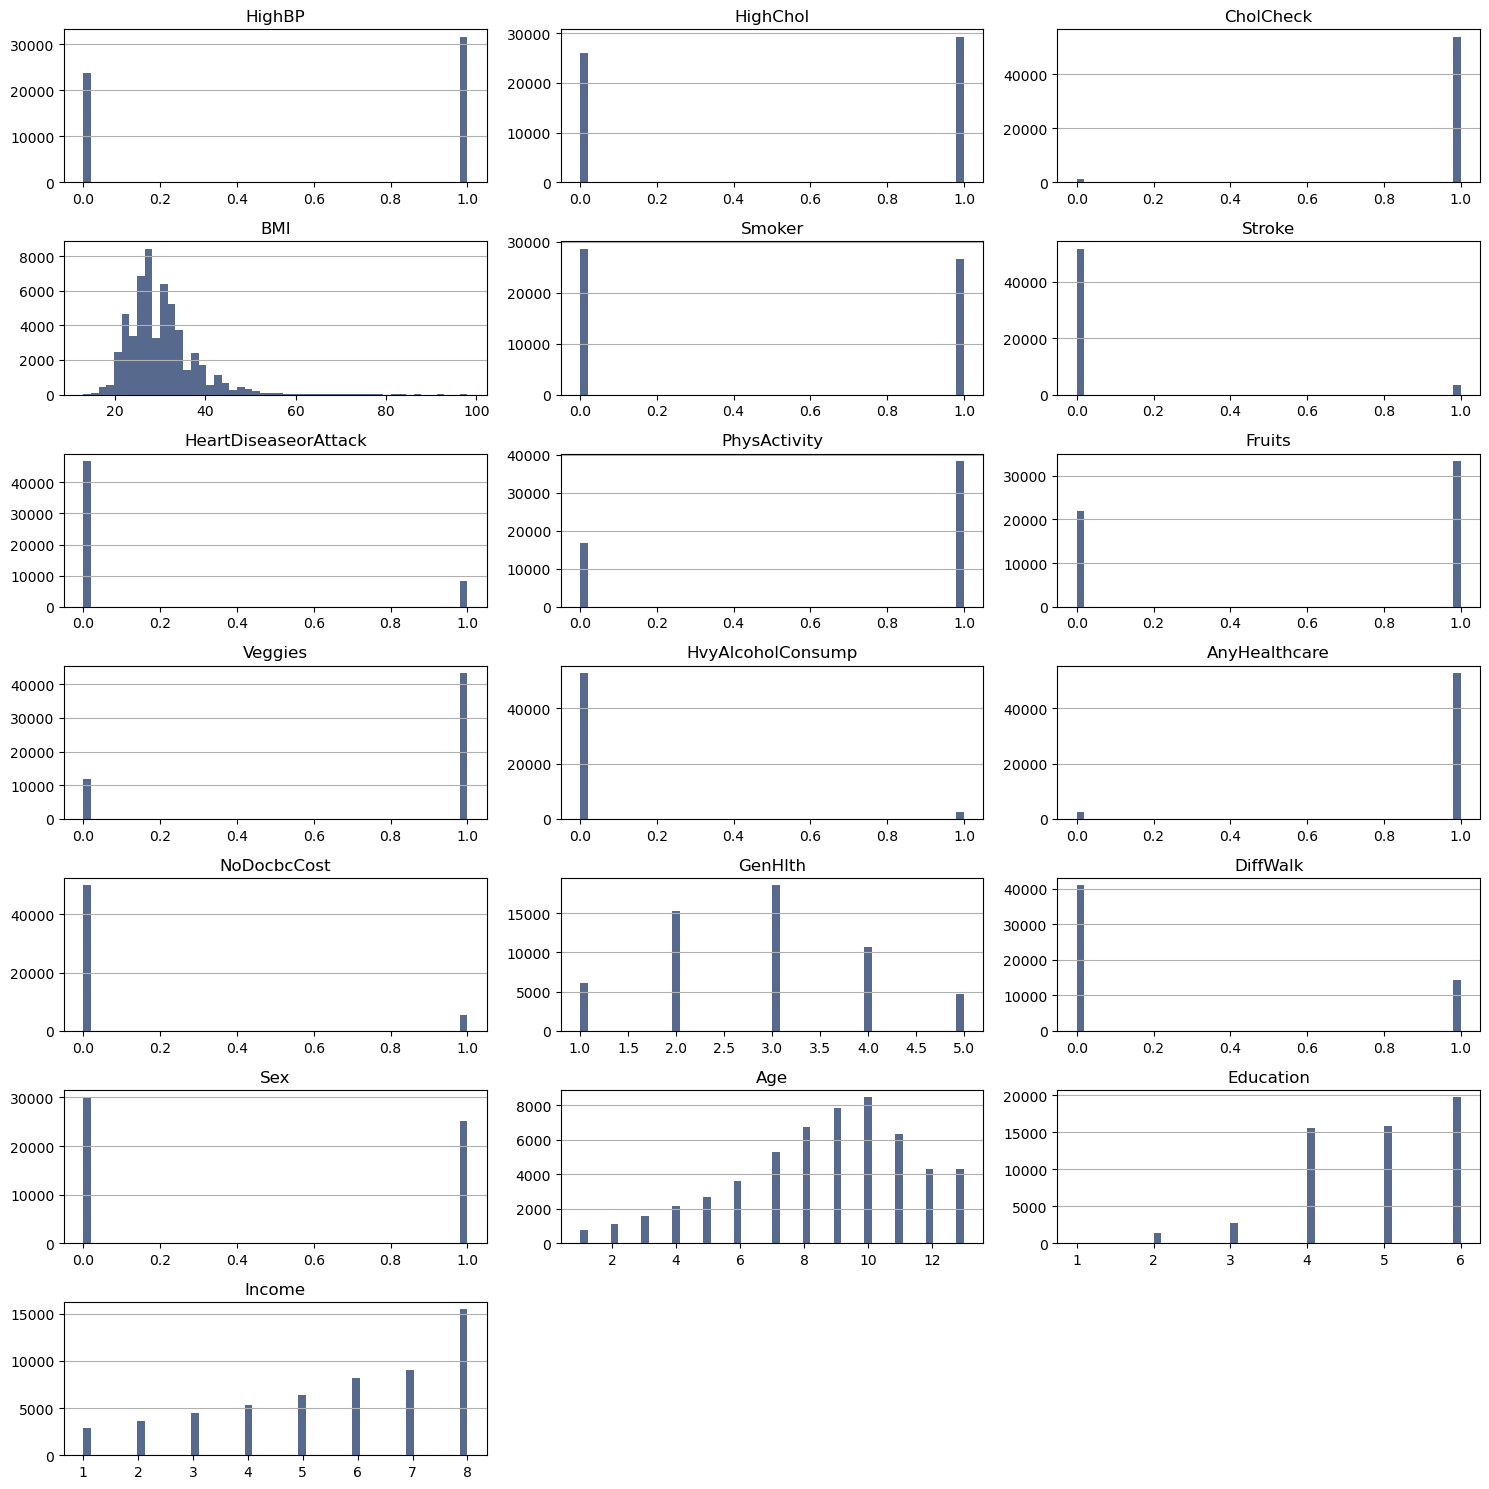

In [8]:
features = train_dropped.columns
n_features = len(features)

fig, axes = plt.subplots(nrows = 7, ncols=3, figsize=(15, 15))

for idx, feature in enumerate(features):
    # Identify row and column in the grid
    row, col = divmod(idx, 3)
    
    # Check if the feature is boolean type
    if np.issubdtype(train_dropped[feature].dtype, np.bool_):
        print("yes")
        Yes_count = np.sum(train_large[feature])
        No_count = len(train_large[feature]) - Yes_count
        axes[row, col].bar(['Yes', 'No'], [Yes_count, No_count], color=blue, alpha = 0.4)
    else:
        # Plot histogram for the current feature
        axes[row, col].hist(train_dropped[feature], bins=50, color=blue, alpha = 0.8,)

    axes[row, col].set_title(feature)
    axes[row, col].grid(axis='y')

# remove empty plots
for ax in axes.ravel()[len(features):]:
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

Most of our features are categorical. Features like **CholCHeck**, **Stroke**, **HeartDiseaseorAttack**, **Vaggies**, **HvyAlcoholConsump**,  **AnyHealthcare**, **NoDocbcCost** are highly concentrated in one category. This suggests that there may be a common characteristic shared among most individuals for each of these features, resulting in skewed distributions. While this skewness in feature distribution does not present the same challenges as an imbalanced target, it may still impact the interpretability and performance of our predictive models, particularly if these features are strongly associated with the target. 

Also, it's appear that the feature **BMI** has outliers that wee need to take a closer look.

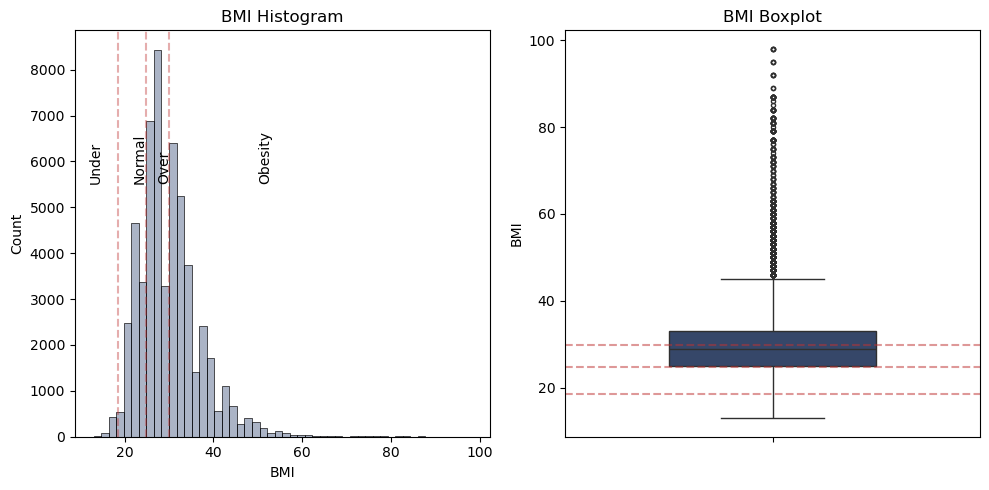

In [9]:
# From World Health Organization (WHO):
#---------------------------
# Under: BMI less than 18.5
# Normal: BMI between 18.5 and 24.9
# Over: BMI between 25 and 29.9
# Obesity: BMI of 30 or greater



fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the histplot on the first axes
sns.histplot(train_dropped['BMI'], bins=50, alpha=0.4, color=blue, ax=axes[0])

for line in [18.5, 24.9, 29.9]:
    axes[0].axvline(line,color=red,linestyle='--',alpha=0.4)

# Add text labels within the second subplot (histplot)
categories = ['Under', 'Normal', 'Over', 'Obesity']
positions = [12, 21.7, 27.45, 50]  # Midpoints between the lines and the ends

for x_pos, cat in zip(positions, categories):
    axes[0].text(x_pos, 5500, cat, rotation=90, size=10, va='bottom')

axes[0].set_title('BMI Histogram')

sns.boxplot(data=train_dropped,y='BMI',color=blue, width=0.5, fliersize=3, ax=axes[1])
axes[1].set_title('BMI Boxplot')

for line in [18.5, 24.9, 29.9]:
    axes[1].axhline(line,color=red,alpha=0.5,linestyle='--')

# Display the plots
plt.tight_layout()
plt.show()

There are numerous outliers, indicating individuals with significantly higher BMI values. Given the skewed distribution and box plot, these outliers do not necessarily represent errors or anomalies in the data but rather a realistic representation of the upper bound of BMI within the population

## **2.2 Feature Importance**

**Mutual Information**

Given that most of our features are binary, having only one numerical feature  for **BMI**, a first natural choice of metric to account correlation would be the Mutual information (MI). MI accounts for linear and non-linear relation, is robust against outliers and can be reliable for any numerical or categorical features.  

Let's compare the MI of the features with the target variable **Diabetes**.

Best correlated features:
 ['GenHlth', 'HighBP', 'BMI', 'Age', 'HighChol', 'DiffWalk', 'Income', 'HeartDiseaseorAttack']


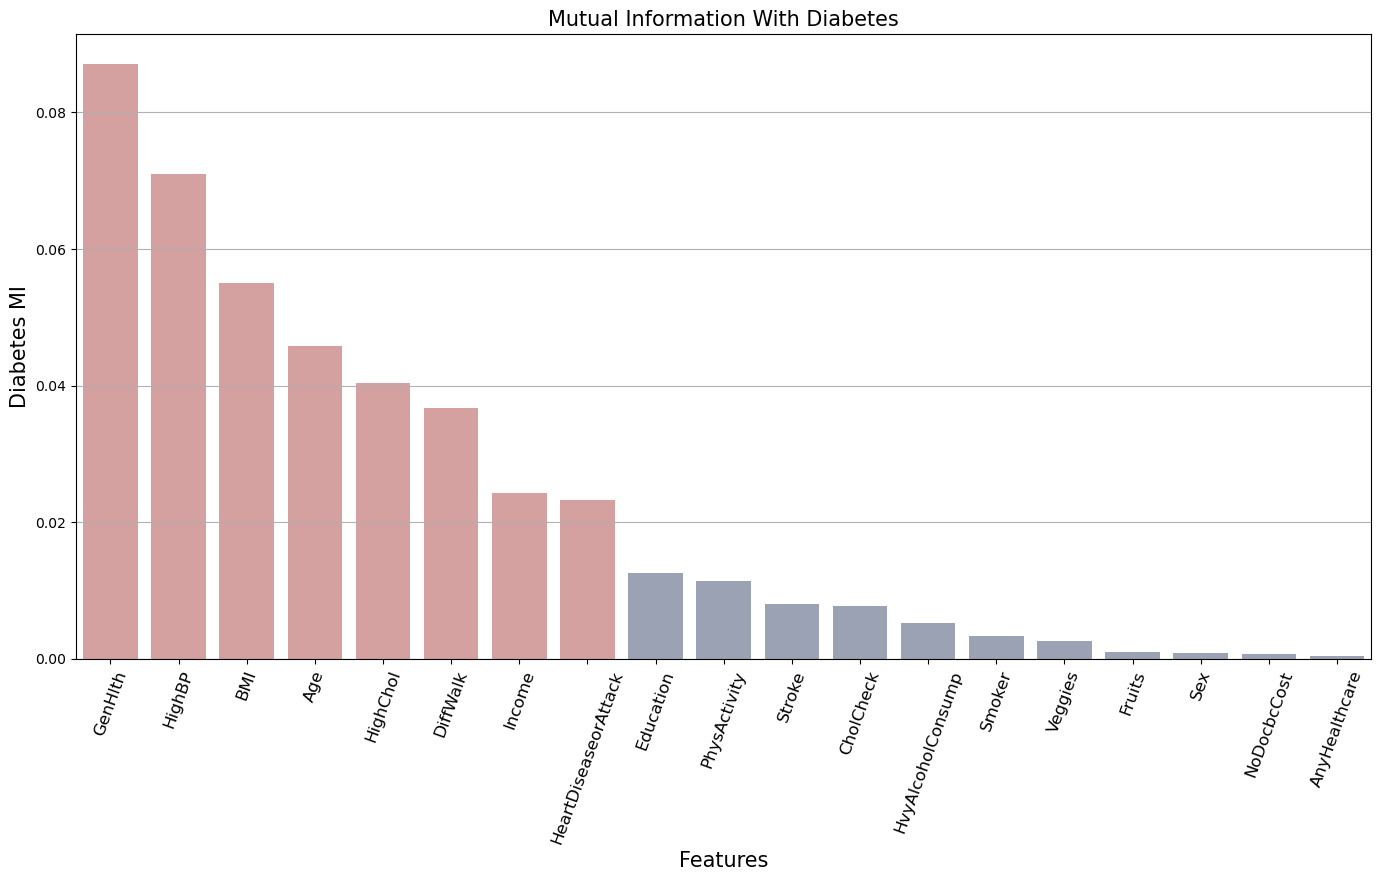

In [10]:
mi_values = mutual_info_classif(train_dropped,Y_train_large,discrete_features=True)
mi_column = pd.DataFrame(mi_values, index=pd.Index(train_dropped.columns, name='features'), 
                         columns=['diabetes_MI']).sort_values(by='diabetes_MI', ascending=False)
# Convert the index 'Features' into a column for plotting
mi_column_reset = mi_column.reset_index()

# Plotting
feature_threshold= 0.020
fig, ax = plt.subplots(figsize=(15, 10))
plot_feature_importance(mi_column_reset, x='features', y='diabetes_MI', ax=ax, threshold=feature_threshold, 
                        title="Mutual Information With Diabetes", xlabel="Features", 
                        ylabel="Diabetes MI", palette=[blue, red])

# Select features with MI > feature_threshold
best_mi_features = list(mi_column[mi_column['diabetes_MI'] > feature_threshold].index)
print("Best correlated features:\n",best_mi_features)

The bars in red represent the features related to the target variable **Diabetes** that preset the most significant entropy reduction. This means that these features provide significant information about the presence of diabetes.

**Spearman Correlation**

Some of our features, like **GenHlth**, **MentHlth**, **PhysHlth**, `**Age**, **Education**, **Income** are ordinal. A useful metric for this case is Spearman Correlation. Spearman Correlation is a non-parametric metric (does not assume any specific distribution for the data) and are more reliable to ordinal data. It captures monotonic relationships, whether linear or not.

Let's compare the Spearman Correlation of the features with the target variable **Diabetes**.

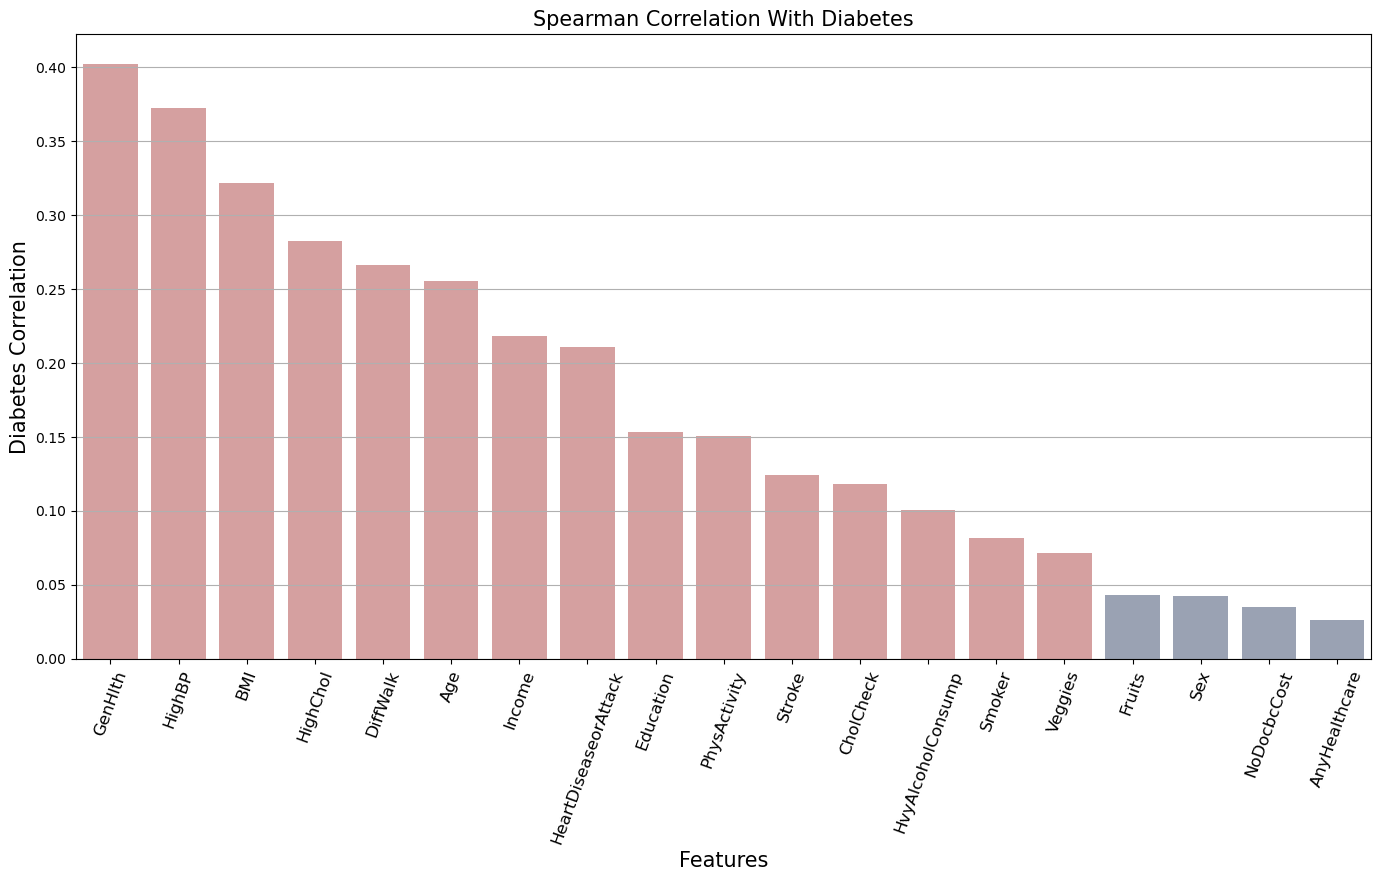

Best correlated features:
 ['GenHlth', 'HighBP', 'BMI', 'HighChol', 'DiffWalk', 'Age', 'Income', 'HeartDiseaseorAttack', 'Education', 'PhysActivity', 'Stroke', 'CholCheck', 'HvyAlcoholConsump', 'Smoker', 'Veggies']


In [11]:
# Calculate Spearman correlation
spearman_corr =train_large.corr(method='spearman')['Diabetes'].agg(np.abs)\
                                                                    .sort_values(ascending=False)\
                                                                    .drop('Diabetes')\
                                                                    .to_frame()
# Convert Spearman correlation to DataFrame and reset index
spearman_column = spearman_corr.reset_index()
spearman_column.columns = ['Features', 'spearman_correlation']

# Plotting
feature_threshold= 0.07
fig, ax = plt.subplots(figsize=(15, 10))
plot_feature_importance(spearman_column, x='Features', y='spearman_correlation', ax=ax, threshold=feature_threshold, 
                        title="Spearman Correlation With Diabetes", xlabel="Features", 
                        ylabel="Diabetes Correlation", palette=[blue, red])

plt.show()

# Select features with Spearman correlation value > feature_threshold
best_spearman_features = spearman_corr[spearman_corr['Diabetes'] >= feature_threshold].index.tolist()
print("Best correlated features:\n", best_spearman_features)

Let's check one more metric, Pearson correlation. While Spearman detects monotonic relationships, Pearson captures linear relationships.

**Pearson Correlation** 

The Pearson correlation accounts only for linear relationships and is very sensitive to outliers. It's not particularly reliable for categorical data, especially binary ones.

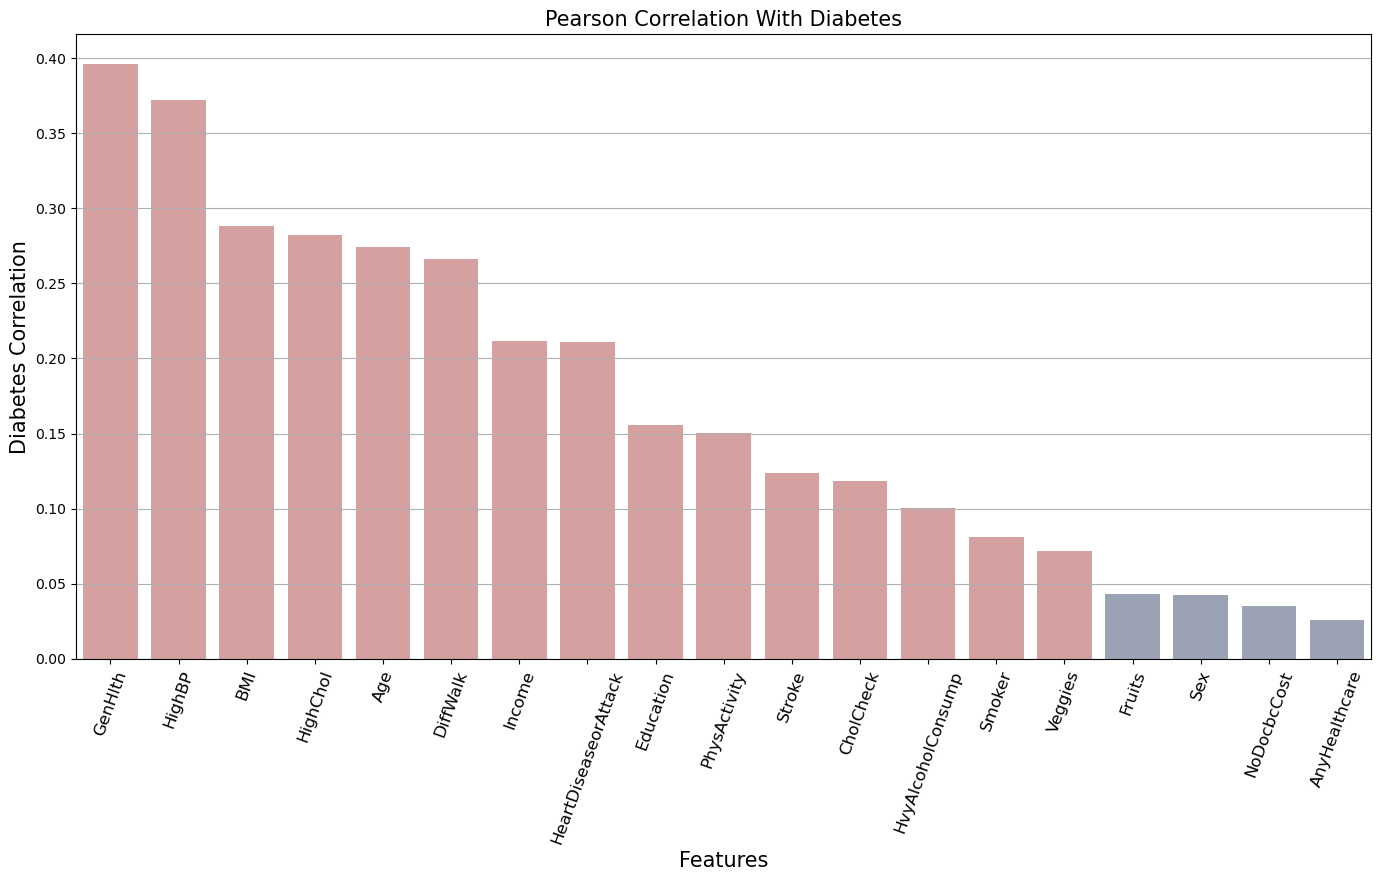

Best correlated features:
 ['GenHlth', 'HighBP', 'BMI', 'HighChol', 'Age', 'DiffWalk', 'Income', 'HeartDiseaseorAttack', 'Education', 'PhysActivity', 'Stroke', 'CholCheck', 'HvyAlcoholConsump', 'Smoker', 'Veggies']


In [12]:
# Calculate Spearman correlation
pearson_corr = train_large.corr(method='pearson')['Diabetes'].agg(np.abs)\
                                                .sort_values(ascending=False)\
                                                .drop('Diabetes')\
                                                .to_frame()

# Convert Spearman correlation to DataFrame and reset index
pearson_column = pearson_corr.reset_index()
pearson_column.columns = ['Features', 'pearson_correlation']

# 
feature_threshold = 0.07
fig, ax = plt.subplots(figsize=(15, 10))
plot_feature_importance(pearson_column, x='Features', y='pearson_correlation', ax=ax, threshold=feature_threshold, 
                        title="Pearson Correlation With Diabetes", xlabel="Features", 
                        ylabel="Diabetes Correlation", palette=[blue, red])

plt.show()


# Select features with correlation value > feature_threshold
best_pearson_features = pearson_corr[pearson_corr['Diabetes'] >= feature_threshold].index.tolist()
print("Best correlated features:\n", best_pearson_features)

Utilizing three distinct metrics — Mutual Information (MI), Pearson, and Spearman — I constructed a schematic representation of a diagram that illustrates the shared and unique characteristics of each metric.

The diagram can provide a better view of how these metrics intersect and which features emerge as a relevant correlation with the target variable.

<center><img src = "Utils/metrics-venn-diagram.png" width="400" height="400"/></center>

Using this idea, let take the overlapping sets of features selected by each metric.

In [13]:
mi_set = set(best_mi_features)
pearson_set = set(best_pearson_features)
spearman_set = set(best_spearman_features)

# Common features across pearson and mutual information
pearson_mi_set = (pearson_set.intersection(mi_set))
print("\n Pearson and MI intersection:\n",pearson_mi_set)

# Common features across spearman and mutual information
spearman_mi_set = (spearman_set.intersection(mi_set))
print("\n Spearman and MI intersection:\n",spearman_mi_set)

# Common features across spearman and pearson
spearman_pearson_set = (spearman_set.intersection(pearson_set))
print("\n Spearman and Pearson intersection:\n",spearman_pearson_set)

# Common features across all three metrics
small_feature_set = mi_set.intersection(pearson_set).intersection(spearman_set)
print("\nAgreement between the three metrics:\n",small_feature_set)


 Pearson and MI intersection:
 {'Age', 'HighBP', 'GenHlth', 'HeartDiseaseorAttack', 'BMI', 'HighChol', 'DiffWalk', 'Income'}

 Spearman and MI intersection:
 {'Age', 'HighBP', 'GenHlth', 'HeartDiseaseorAttack', 'BMI', 'HighChol', 'DiffWalk', 'Income'}

 Spearman and Pearson intersection:
 {'Age', 'Stroke', 'CholCheck', 'HighBP', 'GenHlth', 'Education', 'HeartDiseaseorAttack', 'Smoker', 'BMI', 'HighChol', 'HvyAlcoholConsump', 'Veggies', 'DiffWalk', 'Income', 'PhysActivity'}

Agreement between the three metrics:
 {'Age', 'HighBP', 'GenHlth', 'HeartDiseaseorAttack', 'BMI', 'HighChol', 'DiffWalk', 'Income'}


From this analyze for the correlations we can conclude that the features **BMI**, **GenHlth**, **Age**, **Income**, **HeartDiseaseorAttack**, **DiffWalk**, **HighBP**, **HighChol** appear to have a higher degree of relevance compare to the target **Diabetes**. All three metrics show a agreement for the relevance of these features. 

Now, with a more restricted set of features, it's essential to closely examine the relationship between the each feature and the target variable based on their frequency. To do this, we can create a frequency table and illustrate the results using a bar plot. 

Let's take the set with the common feature across all three metrics to proceed with the analyze.

In [14]:
numerical = ['BMI']
categorical = ['GenHlth', 'Age', 'Income']
binary = ['HighChol','DiffWalk', 'HighBP', 'HeartDiseaseorAttack']

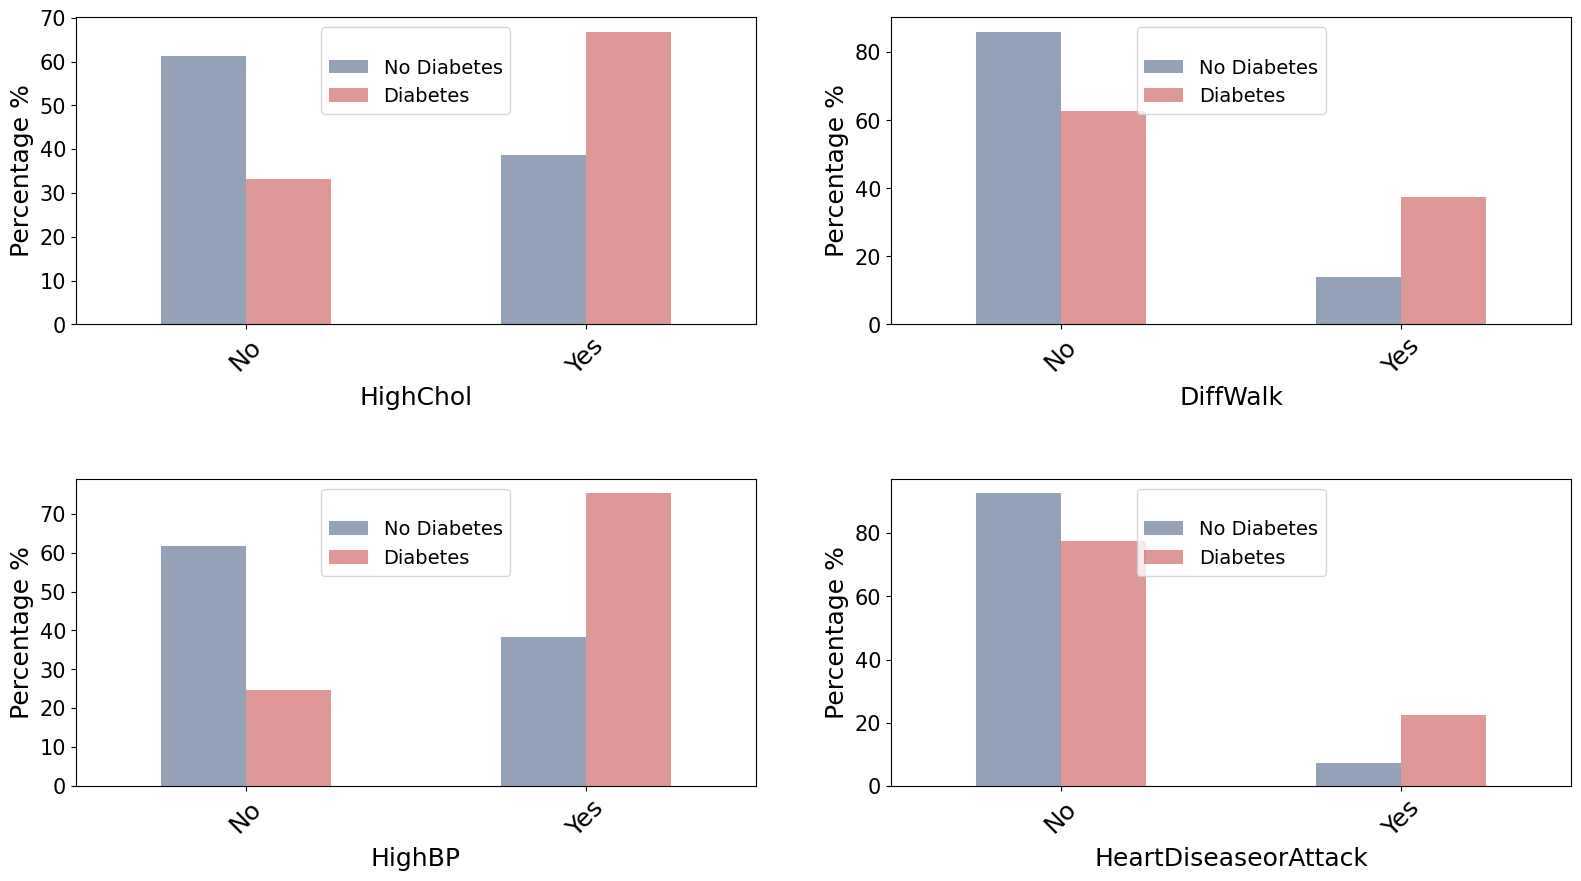

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(17, 10))

for ax, feature in zip(axes.ravel(), binary):

    ct = pd.crosstab(train_dropped[feature], Y_train_large )
    ct_normalized = ct.divide(ct.sum(axis=0), axis=1)*100

    ct_normalized.plot(kind='bar', stacked=False, ax=ax, color = [blue, red],
             alpha = 0.5, fontsize= 15, legend=False  )
    #sns.barplot(x=ct_normalized.index, y= ct_normalized[1], ax=ax, palette = ['#2D4471', '#BE3232'], alpha = 0.5)
    
    ax.set_title('', fontsize=21)
    ax.set_ylabel('Percentage %', fontsize= 18)
    ax.set_xlabel(feature, fontsize= 18)

    ax.set_xticks([0, 1])  
    ax.set_xticklabels(['No', 'Yes'], fontsize=18, rotation=45)
    ax.legend( ['No Diabetes', 'Diabetes'], title=' ', 
               loc='upper center', fontsize = 14)

#for ax in axes.ravel()[len(binary):]:
#    ax.axis('off')

plt.tight_layout(pad=5.0)
plt.show()

For Binary (categorical) data we can use the chi squared test to quantify how independent two categorical variables are, i.e. if there is an association between the two variables. This is achieved by this statistical test by comparing the observed frequencies to expected frequencies in a contingency table for the classes.

In [16]:
cts = {}
for feature in binary:
    ct = pd.crosstab(train_dropped[feature],Y_train_large)
    cts[feature] = ct
    _,p_value,_,_ = chi2_contingency(cts[feature])

    # Null hypothesis: There is no association between the two variables
    if (p_value < 0.05):
        print(f"Significant association between diabetes status and {feature}.")

    else:
        print('Failed to reject Null Hypothesis')

Significant association between diabetes status and HighChol.
Significant association between diabetes status and DiffWalk.
Significant association between diabetes status and HighBP.
Significant association between diabetes status and HeartDiseaseorAttack.


The visualization in a bar plot for **HighChol**, **DiffWalk**, **HighBP** demonstrates a tendency to **Diabetes** when the answer is **Yes**. The visual observation is further supported by the chi-squared test. Thus, it can be inferred that Diabetic patients tend to have higher cholesterol, difficulty walking, and higher blood pressure.

On the other hand, while **HeartDiseaseorAttack** seems to have an association with **Diabetes**, this link is less evident in the visual observation.

**Categorical Ordinal**

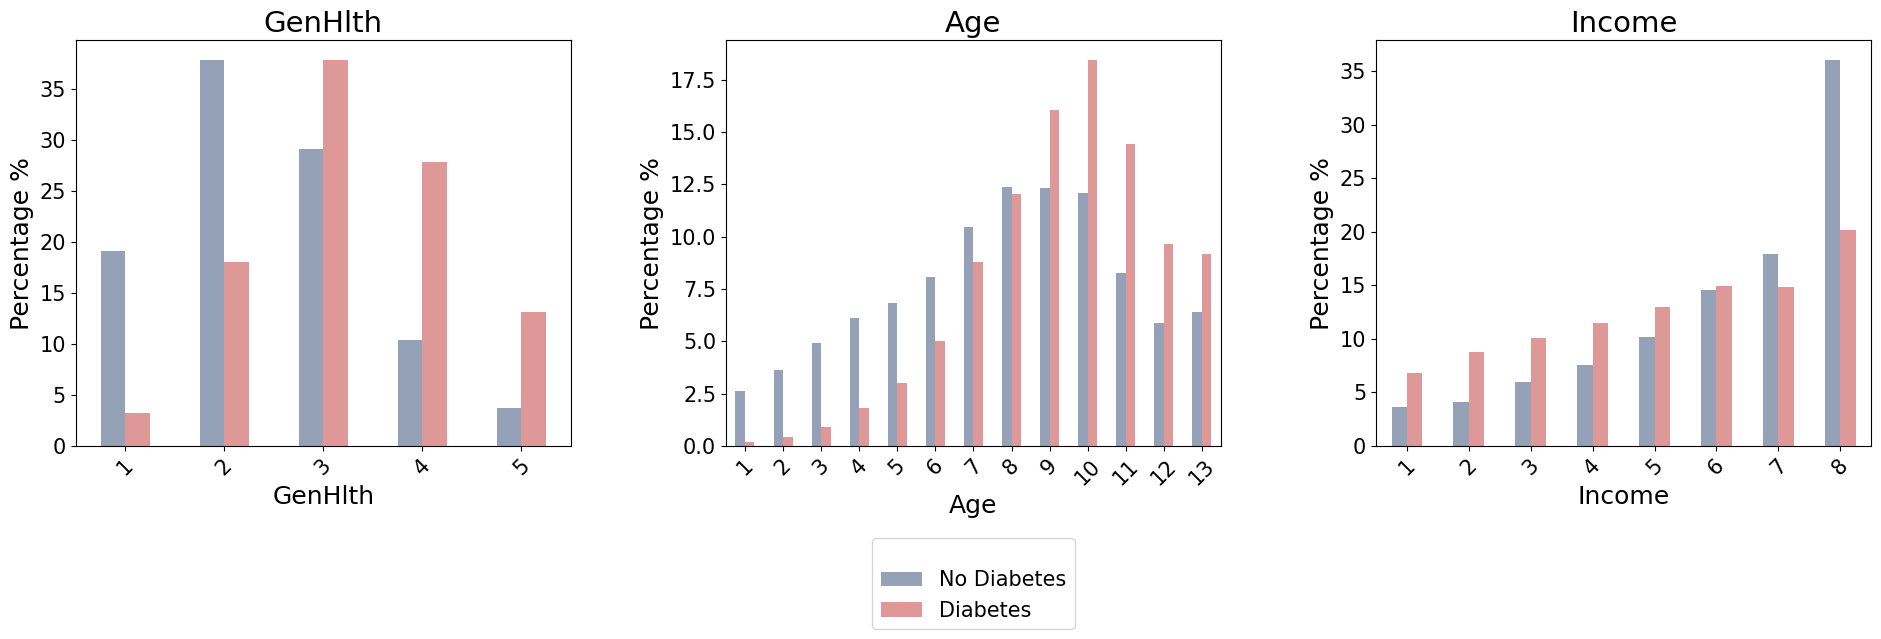

In [17]:
fig, axes = plt.subplots(1, len(categorical), figsize=(20, 8))

for ax, feature in zip(axes.ravel(), categorical):

    ct = pd.crosstab(train_dropped[feature], Y_train_large)
    ct_normalized = ct.divide(ct.sum(axis=0), axis=1)*100

    ct_normalized.plot(kind='bar', stacked=False, ax=ax, color=[blue, red], 
            alpha=0.5, fontsize=15, legend=False)

    ax.set_title(feature, fontsize=21)
    ax.set_ylabel('Percentage %', fontsize=18)
    ax.set_xlabel(feature, fontsize=18)

    # Allow x-axis tick labels to take on unique values for non-binary variables
    ax.tick_params(axis='x', rotation=45, labelsize=15)
    
axes[1].legend(['No Diabetes', 'Diabetes'], title=' ', loc='upper center', 
              bbox_to_anchor=(0.5, -0.2), fontsize=15)

#for ax in axes.ravel()[len(non_binary):]:
#    ax.axis('off')

plt.tight_layout(pad=5.0)
plt.show()

In [18]:
cts = {}
for feature in categorical:
    # Compute the contingency table
    ct = pd.crosstab(train_dropped[feature], Y_train_large)    
    cts[feature] = ct 
    # chi-squared test
    _, p_value, _, _ = chi2_contingency(cts[feature])

    # Null hypothesis: There is no association between the two variables
    if (p_value < 0.05):
        print(f"Significant association between diabetes status and {feature}.")

    else:
        print('Failed to reject Null Hypothesis')

Significant association between diabetes status and GenHlth.
Significant association between diabetes status and Age.
Significant association between diabetes status and Income.


For **GenHlth** it shows a correlation with diabetes. Based on the categories of general health:

1. excellent : less than $5\%$ has diabetes
2. very good : between $15-20 \%$ has diabetes
3. good: more than $35\%$ has diabetes
4. fair: between $25-30 \%$ has diabetes
5. poor: between $10-15 \%$ has diabetes

As general health gets worse, the percentage of individuals diagnosed with diabetes increases. 

For the **Age** we have the following categories:

1. 18-24 
2. 25-29 
3. 30-34
4. 35-39
5. 40-44
6. 45-49
7. 50-54
8. 55-59
9. 60-64
10. 65-69
11. 70-74
12. 75-79
13.  more then 80

There's an observed increment in the percentage of individuals with diabetes as age progresses, though there are some exceptions. This is a good sign, because it is in line with known medical data indicating that the risk of diabetes increases with age.

For **Income** , those individuals with the highest income tend to have an increase in the incidence of diabetes compared to lowest income. But is complex to say more than this, because it does not follow a simple linear trend as for **GenHlth** and **Age**.


**Numerical**

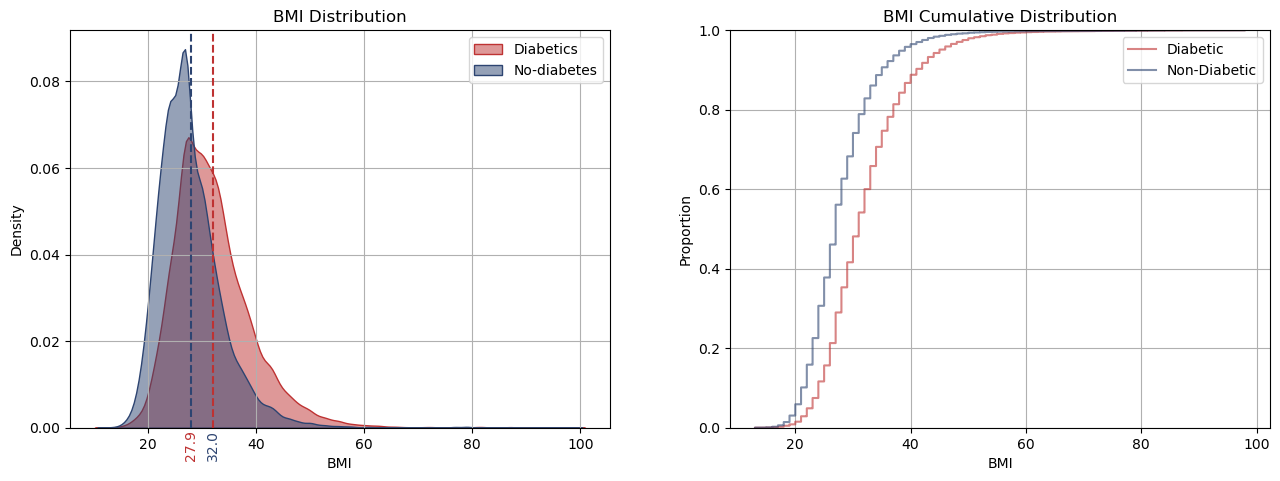

In [19]:
train_no = train_large[train_large['Diabetes'] ==0]
train_yes = train_large[train_large['Diabetes'] ==1]

bmi_no = train_no['BMI']
bmi_yes = train_yes['BMI']

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(14,6))

sns.kdeplot(bmi_yes,ax=axes[0],color=red,fill=True,alpha=0.5)
sns.kdeplot(bmi_no,ax=axes[0],color=blue,fill=True,alpha=0.5)

axes[0].axvline(bmi_no.mean(),color=blue,linestyle='--')
axes[0].axvline(bmi_yes.mean(),color=red,linestyle='--')


axes[0].text(bmi_no.mean(), -0.007, f'{bmi_no.mean():.1f}',
              color=red, rotation=90, ha='center')

axes[0].text(bmi_yes.mean(), -0.007, f'{bmi_yes.mean():.1f}',
              color=blue, rotation=90, ha='center')

axes[0].grid()
axes[0].set_title('BMI Distribution')
axes[0].legend(['Diabetics', 'No-diabetes'])

sns.ecdfplot(bmi_yes,ax=axes[1],color=red,alpha=0.6,label='Diabetic')
sns.ecdfplot(bmi_no,ax=axes[1],color=blue,alpha=0.6,label='Non-Diabetic')

axes[1].grid()
axes[1].set_title('BMI Cumulative Distribution')
axes[1].legend()

plt.tight_layout(pad=5.0)
plt.show()

For numerical data, we employ the t-test to compare the means of two groups: BMI for diabetic patients and BMI for non-diabetic patients.  Because the variances of the groups differ, then Welch's t-test is employed, not assuming equal variances. 

In [20]:
print(f"Diff Variance Between 2 Groups {np.abs(bmi_yes.var()-bmi_no.var())}")

_,p_value = ttest_ind(bmi_yes,bmi_no,equal_var=False)

# Null hypothesis: The two groups have the same mean
if p_value < 0.05:   
    print('Diabetic and non-diabetic have different BMI')
else:
    print('Failed to reject Null Hypothesis')

Diff Variance Between 2 Groups 16.09234619140625
Diabetic and non-diabetic have different BMI


The distributions and cumulative distribution for BMI in diabetic and non-diabetic patients has a significant difference. The BMI distribution for diabetics appears right-skewed, suggesting a tendency towards higher BMI values compared to the more symmetric distribution of non-diabetics. This difference is more evident in their cumulative distributions, which show a significant gap between the curves. This visual observation is further supported by a Welch's t-test, indicating a significant difference in the mean BMI values of the two groups. Thus, it can be inferred that diabetic patients tend to have higher BMIs than non-diabetics

## **2.3 Conclusion from EDA**

After analyzing the data, we found that the best features for training our machine learning model are:

- HighBP
- GenHlth
- HighChol
- DiffWalk
- Age
- BMI
- HeartDiseaseorAttack
- Income

We saw a clear link between these features and the target variable **Diabetes**. But for the **HeartDiseaseorAttack** and **Income** features, it's harder to say exactly how they relate or if the relationship is significant for predicting whether an individual has diabetes. All we can infer is that the relationship is not linear. Also, **HeartDiseaseorAttack** is highly centred in one category, and this could have some influence in this relation with the target variable.


# **3. Model Training and Validation**

Now, with a better understanding of the features and their significance in relation to the target variable **Diabetes**, we can proceed to train a model to evaluate its performance on this set of features identified from the EDA. We consider both a consensus set of features, where all metrics agree, which results in a smaller feature set, and a large set of features selected based on the highest Pearson and mutual information. This approach will allow us to compare the models using different subsets of features, providing a more nuanced understanding of the relevance (or irrelevance) of each feature to the target variable.

In [21]:
# Remove Diabetes, is not necessary anymore
boolean_features = boolean_columns.copy()
boolean_features.remove('Diabetes')
categorical_features  = categorical_columns.copy()

# Best set of features selected from EDA
small_feature_list = list(small_feature_set)

large_feature_set = spearman_pearson_set.union(mi_set)
large_feature_list= list(large_feature_set)

In [22]:
# Best set of features selected from EDA
small_feature_list = list(small_feature_set)
large_feature_list= list(spearman_pearson_set.union(mi_set))

print('\n Small set of features:\n', small_feature_list)
print('\n Large set of features:\n', large_feature_list)

# Change dtypes for logistic regression
dtype_dict_lr = {
    'bool': boolean_features,
    'str': categorical_features,
    'float32': ["BMI"]
}

# Create a copy of dataframe to modify the dtypes
df_train_lr = train.copy()
df_val_lr = val.copy()
df_test_lr = test.copy()

# Change dtypes for logistic regression
dtype_dict_lr = {
    'bool': boolean_features,
    'str': categorical_features,
    'float32': ["BMI"]
}

# Create a copy of dataframe to modify the dtypes
df_train_lr = train.copy()
df_val_lr = val.copy()
df_test_lr = test.copy()

X_train_small, X_val_small, _, _ = preprocess_and_encode_features(df_train_lr, df_val_lr, df_test_lr, small_feature_list,dtype_dict_lr, features_to_scale=['BMI'])

X_train_large, X_val_large, _, _ = preprocess_and_encode_features(df_train_lr, df_val_lr, df_test_lr, large_feature_list,dtype_dict_lr, features_to_scale=['BMI'])
               


 Small set of features:
 ['Age', 'HighBP', 'GenHlth', 'HeartDiseaseorAttack', 'BMI', 'HighChol', 'DiffWalk', 'Income']

 Large set of features:
 ['Age', 'Stroke', 'GenHlth', 'HeartDiseaseorAttack', 'Smoker', 'HighChol', 'HvyAlcoholConsump', 'DiffWalk', 'Income', 'CholCheck', 'HighBP', 'Education', 'BMI', 'Veggies', 'PhysActivity']


### **3.1.1 Hyperparameter tunning and validate**

In [23]:
param_grid_lr = { "C":[0.001, 0.01, 1, 10, 100],
                  "penalty":["l1","l2"],
                  "solver": [ 'liblinear'],
                  'random_state': [42]}

# Grid search and predict on Large Feature Set
best_lr_params, best_score, \
best_estimator, Y_pred_lr_large, \
      val_accuracy = grid_search_and_predict(   LogisticRegression(), 
                                                param_grid_lr, X_train_large, Y_train,
                                                X_val_large, Y_val)

print("\n Tuned hyperparameters :",best_lr_params)
print("\n Accuracy of the best hyperparameters :",round(best_score,3))
print('\n Accuracy for Large Feature Set:', round(val_accuracy, 3))

# Predict on Small Feature Set
accuracy, Y_pred_lr_small = train_and_evaluate( LogisticRegression, 
                                                best_lr_params, 
                                                X_train_small, Y_train, 
                                                X_val_small, Y_val)


print('\n Accuracy for Small Feature Set:', round(accuracy, 3))


 Tuned hyperparameters : {'C': 1, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}

 Accuracy of the best hyperparameters : 0.744

 Accuracy for Large Feature Set: 0.748

 Accuracy for Small Feature Set: 0.744


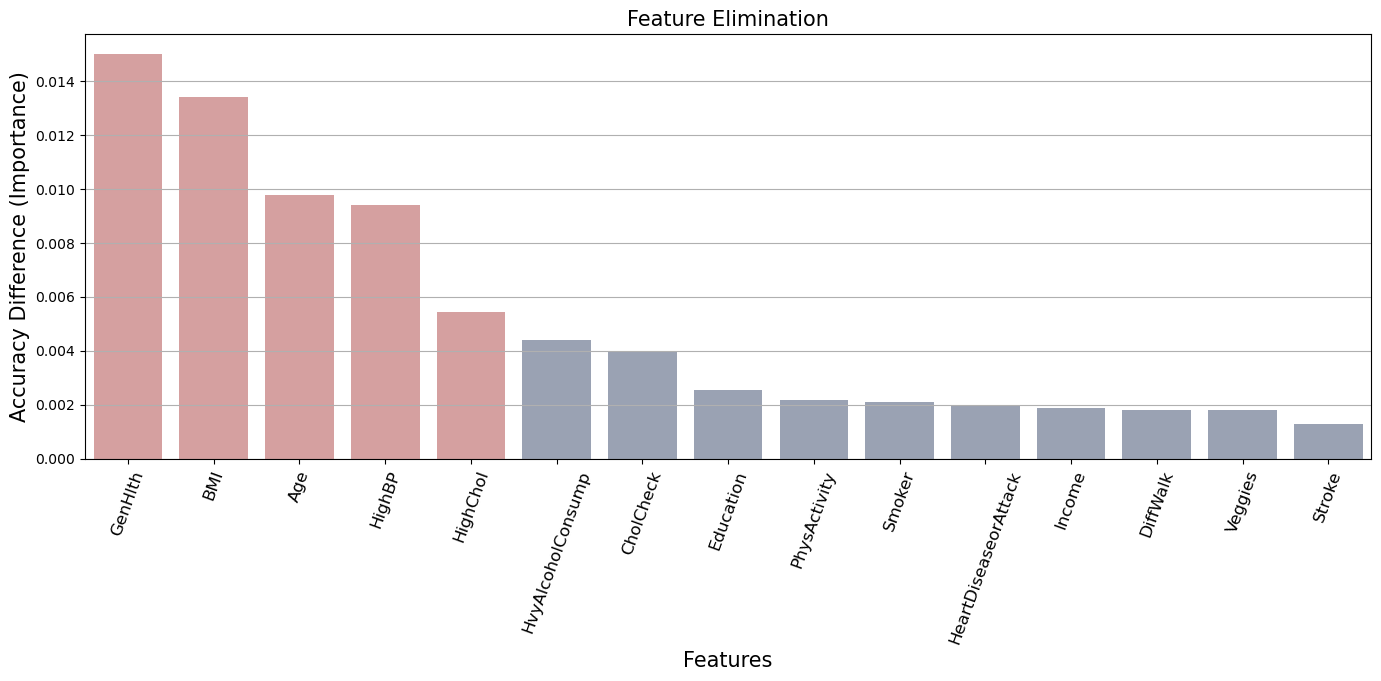


Features importance Logistic Regression:
 {'Age', 'HighBP', 'GenHlth', 'BMI', 'HighChol'}


In [24]:
lr_model = LogisticRegression(**best_lr_params)
feature_importance = feature_elimination(train, val, Y_train, Y_val,
                                   lr_model, accuracy_score, large_feature_list, accuracy_score(Y_pred_lr_large, Y_val) )

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(15, 8))

importance_threshold = 0.005
plot_feature_importance(df = feature_importance, 
                        x="eliminated_feature", 
                        y="accuracy_score_diff", 
                        ax=ax, 
                        threshold=importance_threshold, 
                        pad=5.0, 
                        title='Feature Elimination', 
                        xlabel='Features', 
                        ylabel='Accuracy Difference (Importance)', 
                        palette=[blue, red])

# Display the plot
plt.show()

feature_importance_lr = set(feature_importance[feature_importance['accuracy_score_diff'] >= importance_threshold]['eliminated_feature'])
print('\nFeatures importance Logistic Regression:\n', feature_importance_lr)

The bar plot indicates that the features **GenHlth**, **BMI**, **Age**, **HighBP**, **HighChol** are relevant for the model's accuracy. Removing any of these specific features leads to a large decline in accuracy compared to the others features.

### **3.1.3 Metrics**

In [25]:
lr_metrics_large = classification_metrics(Y_val, Y_pred_lr_large, 'lr_large_set')
lr_metrics_small = classification_metrics(Y_val, Y_pred_lr_small, 'lr_small_set')

lr_metrics = lr_metrics_large.merge(lr_metrics_small, on = 'metrics', how = 'outer')


display(lr_metrics)

,lr_large_set,lr_small_set
metrics,,
Precision,0.738683,0.735145
Recall,0.783458,0.781476
AUC,0.746788,0.743500
F1 Score,0.760412,0.757603


Given that the smaller feature set provides almost equivalent performance to the larger set, specially for the F1 score and the recall metrics, we can conclude that the large set of features has some irrelevant features for the predictive power of the model.

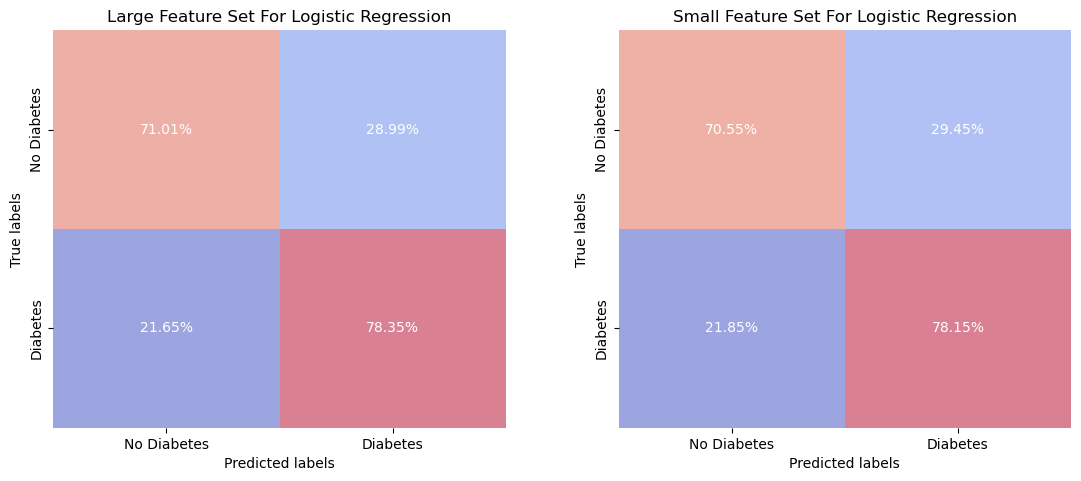

In [26]:
predictions = {
    "Large Feature Set For Logistic Regression": Y_pred_lr_large,  # Predictions using large feature set
    "Small Feature Set For Logistic Regression": Y_pred_lr_small   # Predictions using small feature set
}

# Create plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, (title, Y_pred) in zip(axes.ravel(), predictions.items()):
    plot_confusion_matrix(Y_val, Y_pred, title, ax, xy_legends=['No Diabetes', 'Diabetes'])

plt.tight_layout(pad=5.0)
plt.show()

The models exhibit a demonstrates a reasonably ability in correctly identifying individuals with and without diabetes, with True Positive (sensitivity) rates of 78.35% for the larger feature set and 78.15% for the smaller feature set, and True Negative (specificity) rates of 71.01% and 70.55% respectively. However, in a potential clinical setting, the observed False Negative rates of 21.65% for the larger set and 21.85% for the smaller set could be of problematic, as they represent the proportion of actual diabetic patients who were not identified by the model. Same for the False Positive rates. 

While the balance between precision and recall suggests that the models perform reasonably well for a general application, the consequences of false predictions in a medical context could be bad.

## **3.2 Decision Tree and Random Forest**

In [27]:
df_train_trees = train.copy()
df_val_trees = val.copy()

dtype_dict_trees = {
    'int32': categorical_features + boolean_features
}

df_train_trees = convert_dtypes(df_train_trees, dtype_dict_trees)
df_val_trees = convert_dtypes(df_val_trees, dtype_dict_trees)


# For decision three is need only to select the feature matrix from dataframe
X_train_small, X_val_small = df_train_trees[small_feature_list].values, df_val_trees[small_feature_list].values
X_train_large, X_val_large = df_train_trees[large_feature_list].values, df_val_trees[large_feature_list].values


### **3.2.1 Hyperparameter Tunning And Validate**

**Decision tree**

In [28]:
# Decision Tree
param_grid_dt = {
    'max_depth': [3 ,10, 15 ],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 8, 10],
    'criterion': ['gini'],
    'random_state': [42]
}

best_dt_params, best_score, best_estimator,\
      Y_pred_dt_large, val_accuracy  = grid_search_and_predict(  DecisionTreeClassifier(), param_grid_dt, \
                                                        X_train_large, Y_train, \
                                                        X_val_large, Y_val, cv = 8)

print("\n Tuned hyperparameters :",best_dt_params)
print("\n Accuracy of the best hyperparameters :",round(best_score,3))
print('\n Accuracy for Large Feature Set:', round(val_accuracy, 3))

# Predict on Small Feature Set
accuracy, Y_pred_dt_small = train_and_evaluate( DecisionTreeClassifier, 
                                                best_dt_params, 
                                                X_train_small, Y_train, 
                                                X_val_small, Y_val)

print('\nAccuracy for Small Feature Set::',round(accuracy, 3))


 Tuned hyperparameters : {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2, 'random_state': 42}

 Accuracy of the best hyperparameters : 0.73

 Accuracy for Large Feature Set: 0.732

Accuracy for Small Feature Set:: 0.735


**Random Forest**

In [29]:
# Define the hyperparameter grid for RandomForestClassifier
param_grid_rf = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [8, 10, 15, 20],
    'criterion': ['gini'],
    'n_estimators': [40, 50, 60],
    'random_state': [42]
}


# Use the grid_search_and_predict function to perform GridSearchCV and prediction on large feature set
best_rf_params, best_score, best_estimator,\
      Y_pred_rf_large, val_accuracy= grid_search_and_predict(   RandomForestClassifier(), 
                                                                param_grid_rf, X_train_large, 
                                                                Y_train, X_val_large, Y_val  )

print("\n Tuned hyperparameters :",best_rf_params)
print("\n Accuracy of the best hyperparameters :",round(best_score,3))
print('\n Accuracy for Large Feature Set:', round(val_accuracy, 3))


accuracy_small, Y_pred_rf_small = train_and_evaluate(
    RandomForestClassifier, best_rf_params, X_train_small, Y_train, X_val_small, Y_val
)

print("\nAccuracy for Small Feature Set:", round(accuracy_small, 3))


 Tuned hyperparameters : {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 50, 'random_state': 42}

 Accuracy of the best hyperparameters : 0.745

 Accuracy for Large Feature Set: 0.747

Accuracy for Small Feature Set: 0.746


In [30]:
accuracy_small, Y_pred_rf_small = train_and_evaluate(
    RandomForestClassifier, best_rf_params, X_train_small, Y_train, X_val_small, Y_val
)

### **3.2.2 Feature Importance**

Feature importance in most tree-ensembles is calculated based an importance score. The importance score is a measure of how often the feature was selected for splitting and how much gain in purity was achieved as a result of the selection.

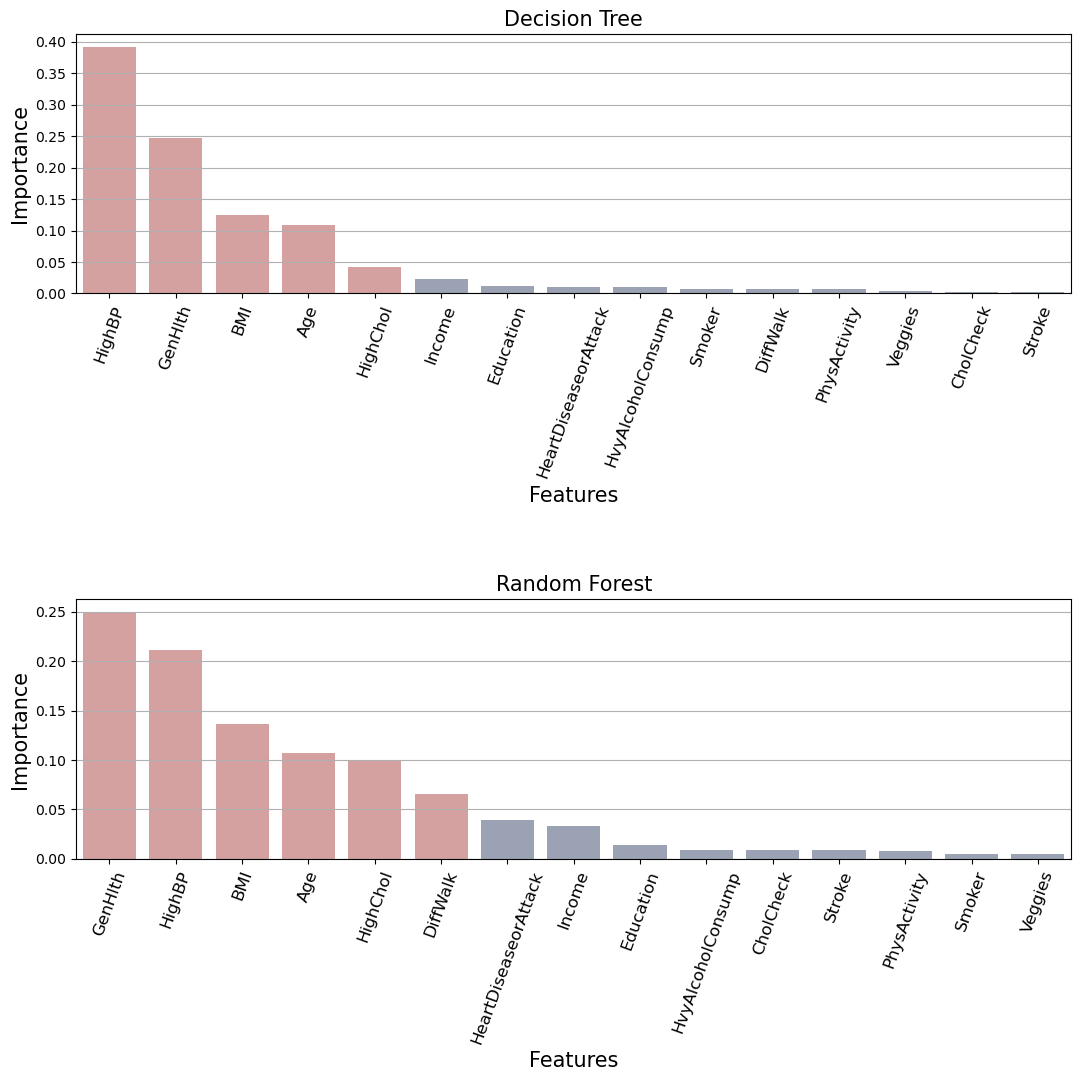

In [31]:
dt_model= DecisionTreeClassifier( **best_dt_params)
dt_model.fit(X_train_large, Y_train)

rf_model = RandomForestClassifier(**best_rf_params)
rf_model.fit(X_train_large, Y_train)

# Extract feature importance
importances_dt = pd.DataFrame( dt_model.feature_importances_ , 
                              index = pd.Index(large_feature_list, name='features'),
                              columns = ['feature_importance'])\
                              .sort_values(by='feature_importance', ascending=False)\
                              .reset_index()

importances_rf =  pd.DataFrame( rf_model.feature_importances_, 
                                index = pd.Index(large_feature_list, name='features'),
                                columns = ['feature_importance'])\
                                .sort_values(by='feature_importance', ascending=False)\
                                .reset_index()


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Plot Decision Tree Feature Importance
feature_threshold = 0.04
plot_feature_importance( df=importances_dt, x='features', y='feature_importance', ax=axes[0],
                         threshold=feature_threshold, title='Decision Tree', palette=[blue, red])

# Plot Random Forest Feature Importance
plot_feature_importance( df=importances_rf, x='features', y='feature_importance', ax=axes[1], 
                         threshold=feature_threshold, title='Random Forest', palette = [blue, red])

plt.tight_layout(pad = 5)
plt.show()

In [32]:
feature_importance_dt = set(importances_dt[importances_dt['feature_importance'] > feature_threshold]['features'])
feature_importance_rf = set(importances_rf[importances_rf['feature_importance'] > feature_threshold]['features'])

best_feature_set = feature_importance_dt.intersection(feature_importance_rf).intersection(feature_importance_lr)

print('Features importance Decision Tree:\n', feature_importance_dt)
print('\nFeatures importance Random Forest:\n', feature_importance_rf)
print('\nFeatures importance Logistic Regression:\n', feature_importance_lr)
print('\n Agreement between the three models:\n', best_feature_set)

Features importance Decision Tree:
 {'Age', 'HighBP', 'GenHlth', 'BMI', 'HighChol'}

Features importance Random Forest:
 {'Age', 'HighBP', 'GenHlth', 'BMI', 'HighChol', 'DiffWalk'}

Features importance Logistic Regression:
 {'Age', 'HighBP', 'GenHlth', 'BMI', 'HighChol'}

 Agreement between the three models:
 {'Age', 'HighBP', 'GenHlth', 'BMI', 'HighChol'}


### **3.2.3 Metrics**

In [33]:
dt_metrics_large = classification_metrics(Y_val, Y_pred_dt_large, 'dt_large_set')
dt_metrics_small = classification_metrics(Y_val, Y_pred_dt_small, 'dt_small_set')
dt_metrics = dt_metrics_large.merge(dt_metrics_small, on = 'metrics', how = 'outer')

rf_metrics_large = classification_metrics(Y_val, Y_pred_rf_large, 'rf_large_set')
rf_metrics_small = classification_metrics(Y_val, Y_pred_rf_small, 'rf_small_set')
rf_metrics = rf_metrics_large.merge(rf_metrics_small, on = 'metrics', how = 'outer')

trees_metrics = dt_metrics.merge(rf_metrics, on = 'metrics', how = 'outer')
display(trees_metrics)

,dt_large_set,dt_small_set,rf_large_set,rf_small_set
metrics,,,,
Precision,0.725020,0.728750,0.730978,0.729733
Recall,0.766605,0.768588,0.800028,0.798046
AUC,0.731251,0.734687,0.746037,0.744453
F1 Score,0.745233,0.748139,0.763946,0.762362


As we concluded for the logistic regression model, the smaller feature set provides almost equivalent performance to the larger set, specially for the F1 score and the recall metrics. which again suggests that the smaller feature set may contain the most relevant features.


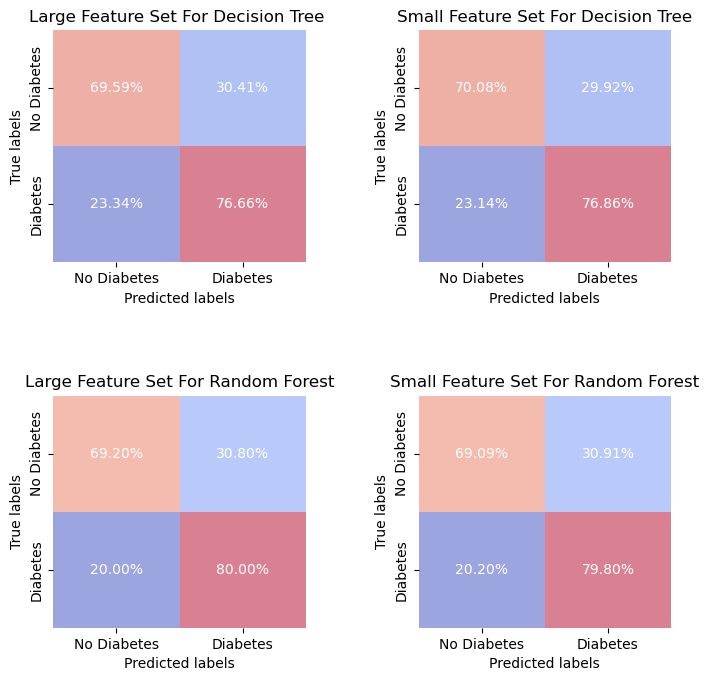

In [34]:
predictions = {
    "Large Feature Set For Decision Tree ": Y_pred_dt_large, 
    "Small Feature Set For Decision Tree": Y_pred_dt_small,
    "Large Feature Set For Random Forest": Y_pred_rf_large,
    "Small Feature Set For Random Forest": Y_pred_rf_small  

}

# Create plots
fig, axes = plt.subplots(2, 2, figsize=((8, 8)))

for ax, (title, Y_pred) in zip(axes.ravel(), predictions.items()):
    plot_confusion_matrix(Y_val, Y_pred, title, ax, xy_legends=['No Diabetes', 'Diabetes'])

plt.tight_layout(pad=5.0)
plt.show()

The Decision Tree and Random Forest models perform similarly for the different sets, with Random Forest showing a better predictive power in identifying true positives (correctly classify a diabetic individual) with 79.66%. The false negative rates are relatively low for all models, which is critical for a clinical test. This also confirm a suspected about redundancy in the larger feature set.

## **3.3 Selecting Model And Best Set Of Features**

In [35]:
# Best set of features from the models
best_features_list = list(best_feature_set)

# Compare the difference between the sets of features
diff_feature_set = small_feature_set.difference(best_feature_set)

print('Features in small set but not in best set:\n', diff_feature_set)

Features in small set but not in best set:
 {'DiffWalk', 'Income', 'HeartDiseaseorAttack'}


In [36]:
# Best set of features from the models
best_features_list = list(best_feature_set)

X_train_lr, X_val_lr, _, _ = preprocess_and_encode_features(df_train_lr, df_val_lr, df_test_lr, best_features_list,
                                                                      dtype_dict_lr, features_to_scale=['BMI'])

X_train_trees, X_val_trees = df_train_trees[best_features_list].values, df_val_trees[best_features_list].values


# Logistic Regression
lr_accuracy, Y_pred_lr_best = train_and_evaluate(LogisticRegression, 
                                                 best_lr_params, 
                                                 X_train_lr, Y_train, 
                                                 X_val_lr, Y_val)

# Decision Tree
dt_accuracy, Y_pred_dt_best = train_and_evaluate(DecisionTreeClassifier, 
                                                 best_dt_params, 
                                                 X_train_trees, Y_train, 
                                                 X_val_trees, Y_val)

# Random Forest
rf_accuracy, Y_pred_rf_best = train_and_evaluate(RandomForestClassifier, 
                                                 best_rf_params, X_train_trees, 
                                                 Y_train, X_val_trees, Y_val)

# Print accuracy for each model
print("Logistic Regression Accuracy for best features set:", round(lr_accuracy, 3))
print("Decision Tree Accuracy for best features set:", round(dt_accuracy, 3))
print("Random Forest Accuracy for best features set:", round(rf_accuracy, 3))

Logistic Regression Accuracy for best features set: 0.742
Decision Tree Accuracy for best features set: 0.736
Random Forest Accuracy for best features set: 0.742


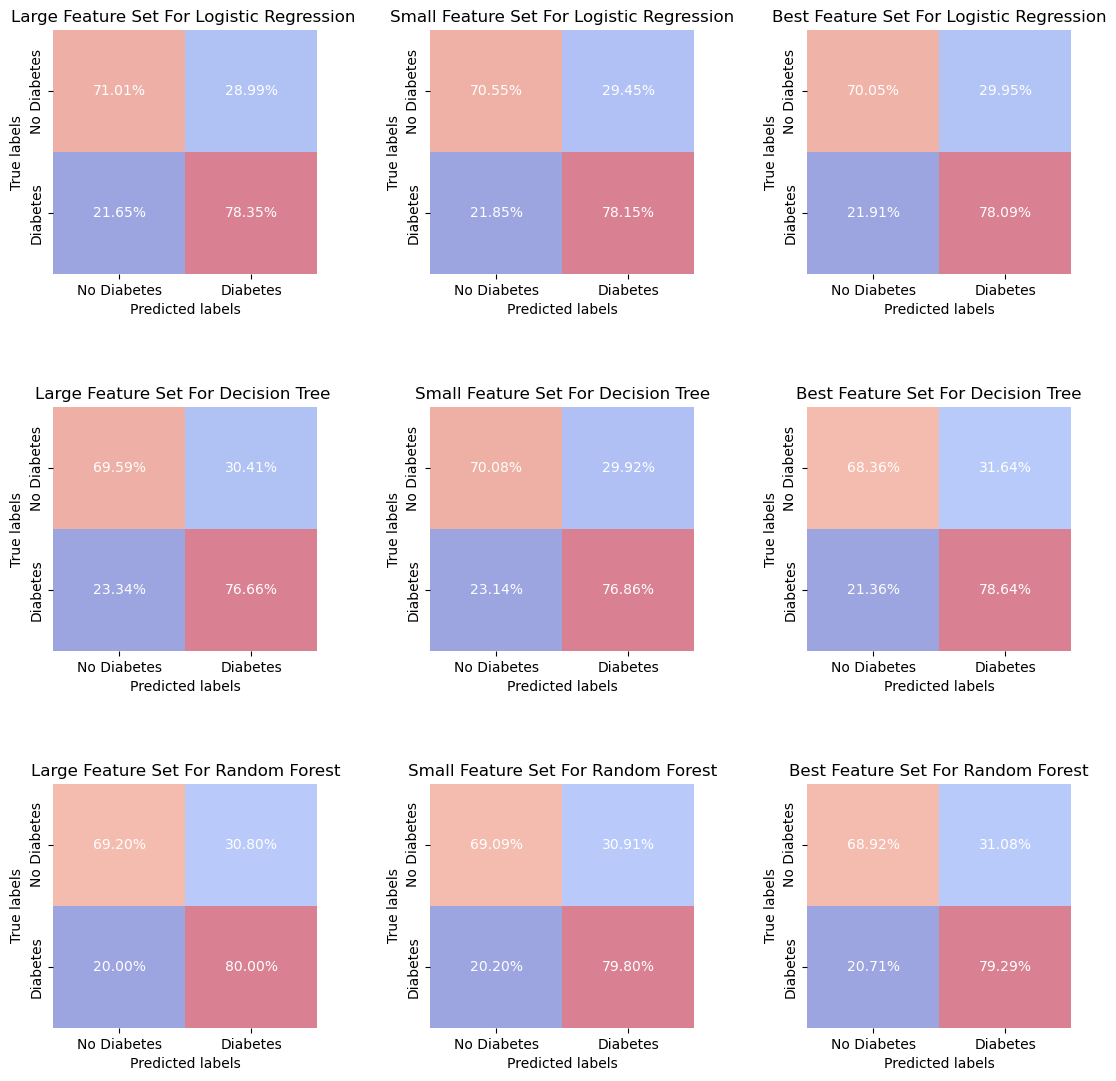

In [37]:
predictions = {
    "Large Feature Set For Logistic Regression ": Y_pred_lr_large, 
    "Small Feature Set For Logistic Regression": Y_pred_lr_small,
    "Best Feature Set For Logistic Regression": Y_pred_lr_best,
    "Large Feature Set For Decision Tree ": Y_pred_dt_large, 
    "Small Feature Set For Decision Tree": Y_pred_dt_small,
    "Best Feature Set For Decision Tree": Y_pred_dt_best,
    "Large Feature Set For Random Forest": Y_pred_rf_large,
    "Small Feature Set For Random Forest": Y_pred_rf_small,
    "Best Feature Set For Random Forest": Y_pred_rf_best
}

# Create plots
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for ax, (title, Y_pred) in zip(axes.ravel(), predictions.items()):
    plot_confusion_matrix(Y_val, Y_pred, title, ax, xy_legends=['No Diabetes', 'Diabetes'])

plt.tight_layout(pad=5.0)
plt.show()

The best feature set consistently outperforms or matches the performance of the large and small feature sets in predicting both classes across all models! This is very good news, because implies that feature selection has been effective in improving model performance, reducing the complexity of the model.

One conclusion that we could drawn from this analyze is that the minor differences between the feature set performances may suggest that the models are somewhat robust to the features selected, or it may indicate that all sets contain the most critical features needed for making predictions.

In [38]:
lr_metrics_best = classification_metrics(Y_val, Y_pred_lr_best, 'lr_best_set')
dt_metrics_best = classification_metrics(Y_val, Y_pred_dt_best, 'dt_best_set')
rf_metrics_best = classification_metrics(Y_val, Y_pred_rf_best, 'rf_best_set')

metrics_best = lr_metrics_best.merge(dt_metrics_best, on = 'metrics', how = 'outer')\
                              .merge(rf_metrics_best, on = 'metrics', how = 'outer')

lr_metrics_large = classification_metrics(Y_val, Y_pred_lr_large, 'lr_large_set')
dt_metrics_large = classification_metrics(Y_val, Y_pred_dt_large, 'dt_large_set')
rf_metrics_large = classification_metrics(Y_val, Y_pred_rf_large, 'rf_large_set')

metrics_large = lr_metrics_large.merge(dt_metrics_large, on = 'metrics', how = 'outer')\
                                .merge(rf_metrics_large, on = 'metrics', how = 'outer')

metrics_small = lr_metrics_small.merge(dt_metrics_small, on = 'metrics', how = 'outer')\
                                .merge(rf_metrics_small, on = 'metrics', how = 'outer')

all_metrics = metrics_best.merge(metrics_large, on = 'metrics', how = 'outer')\
                          .merge(metrics_small, on = 'metrics', how = 'outer')
                           
display(all_metrics)

,lr_best_set,dt_best_set,rf_best_set,lr_large_set,dt_large_set,rf_large_set,lr_small_set,dt_small_set,rf_small_set
metrics,,,,,,,,,
Precision,0.731688,0.722201,0.727426,0.738683,0.725020,0.730978,0.735145,0.728750,0.729733
Recall,0.780909,0.786433,0.792947,0.783458,0.766605,0.800028,0.781476,0.768588,0.798046
AUC,0.740699,0.735017,0.741089,0.746788,0.731251,0.746037,0.743500,0.734687,0.744453
F1 Score,0.755498,0.752949,0.758775,0.760412,0.745233,0.763946,0.757603,0.748139,0.762362


The minor differences between the metrics become clearer upon closer inspection. For example, the AUC values are quite close across all models, suggesting a consistent ability to distinguish between positive and negative classes. Furthermore, the F1 Score and Recall metrics indicate that the models excel at accurately identifying relevant cases with a low count of false negatives.

The most balanced model in terms of complexity and predictive power is the Random Forest with the best feature set, which contains only five features for this model.

# **4. Model Evaluation on Test Set**

Next, we'll evaluate the models on the test set. This step is important to confirm that the models' performance is consistent with the validation results and to demonstrate their predictive stability on unseen data. For this section we only use the best set of features: **BMI**, **GenHlth**, **Age**, **HighBP**, and **HighChol**.

**Logistic Regression**

In [39]:
best_features_list = list(best_feature_set)
X_train_lr, _, X_test_lr, _ = preprocess_and_encode_features(df_train_lr, df_val_lr, df_test_lr, best_features_list,
                                                                      dtype_dict_lr, features_to_scale=['BMI'])


# Logistic Regression
lr_accuracy, Y_pred_lr_test = train_and_evaluate(LogisticRegression, 
                                                 best_lr_params, 
                                                 X_train_lr, Y_train, 
                                                 X_test_lr, Y_test)

print('Accuracy for Logistic Regression on test set:\n', round(lr_accuracy, 3))

Accuracy for Logistic Regression on test set:
 0.738


**Decision Tree and Random Forest**

In [42]:
df_train_trees = train.copy()
df_test_trees = test.copy()

dtype_dict_trees = {
    'int32': categorical_features + boolean_features
}

df_train_trees = convert_dtypes(df_train_trees, dtype_dict_trees)
df_test_trees = convert_dtypes(df_test_trees, dtype_dict_trees)

# For decision three is need only to select the feature matrix from dataframe
X_train_trees, X_test_trees = df_train_trees[best_features_list].values, df_test_trees[best_features_list].values

# Decision Tree
dt_accuracy, Y_pred_dt_test = train_and_evaluate(DecisionTreeClassifier, 
                                                 best_dt_params, 
                                                 X_train_trees, Y_train, 
                                                 X_test_trees, Y_test)

# Random Forest
rf_accuracy, Y_pred_rf_test = train_and_evaluate(RandomForestClassifier, 
                                                 best_rf_params, 
                                                 X_train_trees, Y_train,
                                                 X_test_trees, Y_test)

print('Accuracy for Decision Tree on test set:\n', round(dt_accuracy, 3))

print('Accuracy for Random Forest on test set:\n', round(rf_accuracy, 3))

Accuracy for Decision Tree on test set:
 0.731
Accuracy for Random Forest on test set:
 0.734


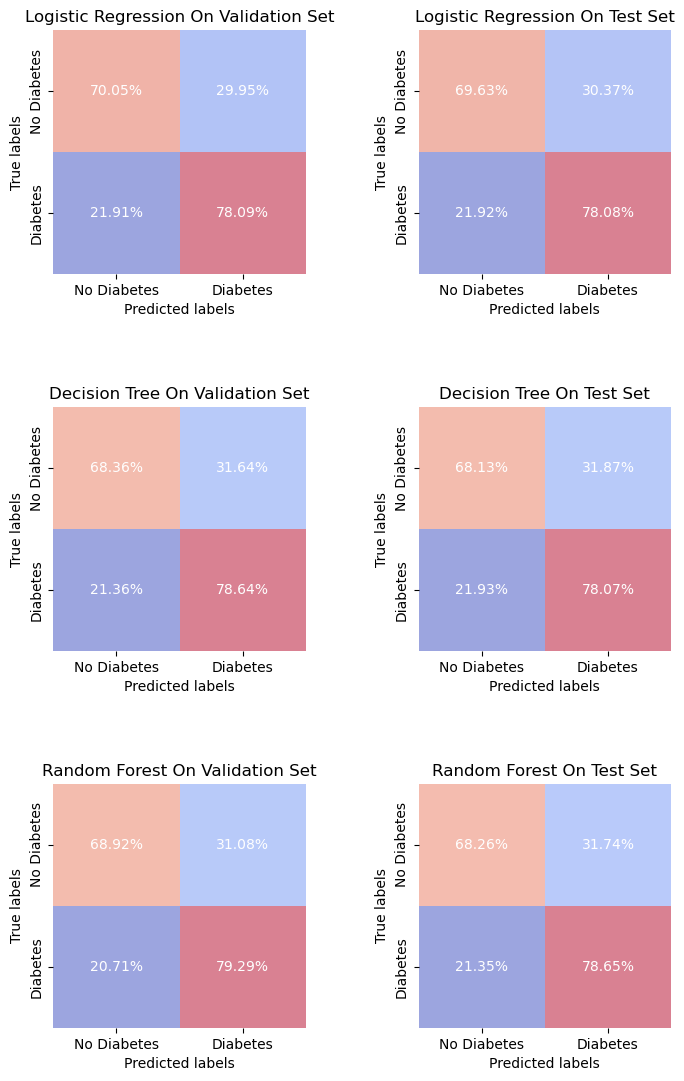

In [43]:
# predictions on validation set with best features set
Y_pred_lr_val = Y_pred_lr_best
Y_pred_dt_val = Y_pred_dt_best
Y_pred_rf_val = Y_pred_rf_best

predictions = {
    "Logistic Regression On Validation Set": (Y_val, Y_pred_lr_val),
    "Logistic Regression On Test Set": (Y_test, Y_pred_lr_test),
    "Decision Tree On Validation Set": (Y_val, Y_pred_dt_val),
    "Decision Tree On Test Set": (Y_test, Y_pred_dt_test),
    "Random Forest On Validation Set": (Y_val, Y_pred_rf_val),
    "Random Forest On Test Set": (Y_test, Y_pred_rf_test)
}

fig, axes = plt.subplots(3, 2, figsize=(8, 12))

for ax, (title,  (Y_true, Y_pred)) in zip(axes.ravel(), predictions.items()):
        plot_confusion_matrix(Y_true, Y_pred, title, ax, xy_legends=['No Diabetes', 'Diabetes'])

plt.tight_layout(pad=5.0)
plt.show()

Each model shows a level of consistency between the validation set and test set, with only slight variations in the percentages of true positives (individuals correctly predicted with diabetes) and true negatives (individuals correctly predicted without diabetes), as well as false positives and false negatives.  This suggests that the models are likely generalizing well and not overfitting to the validation data.

Also, we can note that the Random Forest model shows a high recall with a slight advantage in minimizing false positives (incorrectly predicts diabetes in an individual ), it could be considered the most stable model among the three, especially if the priority is to minimize false negatives.

# **4. Conclusions**

From the exploratory data analysis (EDA), we identified the possibility of dropping some redundant features from the dataset out of the initial 22, leading to two subsets: the 'small feature set' (with features agreed upon by all correlation metrics) and the 'large feature set' (a union of features selected by both Mutual Information and Pearson Correlation).

In the Model Training and Validation section we showed that both feature sets produced similar outcomes across Logistic Regression, Decision Tree, and Random Forest models, with only slight variances in accuracy and other metrics such as F1 Score, Precision, Recall, and AUC. The Features selected by the models shows to be a even smaller set of feature, with only five features, that demonstrates also a high predictive power with only a marginal difference from the other features set.

The challenge in reducing the false negative rate (individuals wrongly classified with diabetes) from the different models may be due the possible skewed class distribution of the features **CholCHeck**, **Stroke**, **HeartDiseaseorAttack**, **Vaggies**, **HvyAlcoholConsump**,  **AnyHealthcare**, **NoDocbcCost**, as noted previously in the EDA. One idea for improvement for the dataset in a future work may be focus on adding another tables from [Kaggle](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?select=diabetes_012_health_indicators_BRFSS2015.csv) that can be used complementary to the one used here. 

A important information from our analysis is the indicative that the features **BMI**, **GenHlth**, **Age**, **HighBP**, and **HighChol** are the most predictive risk factors for diabetes, consistent with established clinical insights. Our project could reduce the feature space from 22 possible risk factors to just a subset of five, which simplified the predictive model without compromising accuracy. 

The Random Forest model, using these five risk factors, proved to be the most balanced in terms of complexity and predictive capacity, and was selected for the final model deployment.


# 5. **Prepare For Deployment**

In [44]:
# libraries for saving the model and requesting data from the API
from joblib import dump
import requests

In [51]:
# Make copies of the dataframes
df_train_trees = train.copy()
df_val_trees = val.copy()
df_test_trees = test.copy()

# preprocess
dtype_dict_trees = {
    'int32': categorical_features + boolean_features
}

df_train_trees = convert_dtypes(df_train_trees, dtype_dict_trees)
df_test_trees = convert_dtypes(df_test_trees, dtype_dict_trees)
df_val_trees = convert_dtypes(df_val_trees, dtype_dict_trees)

# Save trained Model
X_train_trees = df_train_trees[best_features_list].values
print('\nRandom Forest Best Parameters:\n', best_rf_params)
rf_model = RandomForestClassifier(**best_rf_params)
rf_model.fit(X_train_trees, Y_train)

# Save trained Model as a joblib file
dump(rf_model, 'random_forest_model.joblib')

# Additionally, save trained Model as a binary file
with open('random_forest_model.bin', 'wb') as f_out:
    dump(rf_model, f_out)

# Add the target variable back to the dataframes
df_train_trees['Diabetes'] = Y_train
df_val_trees['Diabetes'] = Y_val
df_test_trees['Diabetes'] = Y_test

#  Save DataFrames with the target variable
target_feature_list = best_features_list + ['Diabetes']
df_train_trees[target_feature_list].to_csv('Data/train_data.csv')
df_test_trees[target_feature_list].to_csv('Data/test_data.csv')
df_val_trees[target_feature_list].to_csv('Data/val_data.csv')


Random Forest Best Parameters:
 {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 50, 'random_state': 42}
